# Yearly Maxima Return Level Estimation: Example 1

This notebook provides a practical implementation using the `R` language of the guidelines for statistical analysis of yearly maxima edicted by the FOEN. In particular, we aim to estimate the return level function, and in particular the 10-year return level, of groundwater level that can be used as reference for civil engineering infrastructure design. 

Example 1 that is treated in this notebook is the simplest example (along with example 2) out of the four datasets that acompanies the guidelines. This example does not require trend estimation to obtain a sample of observations satifiying the necessary assumptions for statistical analysis and accurate uncertainty estimation. For illustration purposes, example 1 also includes parameters model estimation using maximum likelihood.

The analysis is performed thanks the the `R` language and requires mulitples `R` packages that needs to be installed before starting the analysis. The latter can be done with commands such as `install.packages("lubridate")` exemplifying intallationg of the lubridate package.

On the Renku platform where the guildelines' notebooks are strored and share, the project has been prepared with all packages installed for easiest reproduction.

In [1]:
# Load necessary libraries

# Library for easy date manipulation
library(lubridate) 

#Library for estimation of parametric models using l-moment matching
library(lmom)

#Library for estimation of parametric EVT models using maximum likelihood
library(evd)

# Library for automatic trend estimation
library(mgcv)

# Library for data manipulation
library(dplyr)

# Libraries for data plotting
library(ggplot2)
library(repr)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




With all necessary libraries now loaded, we import the data into the R environment. In our case, the data is stored as a `.csv` file with four columns and corresponding titles. Thanks to the `read.csv` function in `R`, we convert the csv into a data.frame object, the `R` representation of datasets, that has the following columns:
* Zeitstempel (date object): date (and time if available) of the measurement,
* Wert (numeric): measured groundwater level,
* Jahre (numeric): Year of the measurement used to compute yearly maxima,
* Zeitstempel_seit_ersten_wert (numeric): numerical time since the beginning of the measures.

File format other than `.csv` are possible, but the `R` code must be adapted accordingly. Extensive documentation on data importation in `R` is widely available on the web.

In [2]:
# Read and import data from csv file
data <- read.csv("../data/data_groundwater_level_1.csv", header = TRUE, sep = ",")

# Converte date as string into date object
data$Zeitstempel <- ymd(data$Zeitstempel)

# Create column with year for block computation
data$Jahre <- (year(data$Zeitstempel))

#Create column with numerical time for trend estimation
data$Zeitstempel_seit_ersten_wert <- as.numeric(data$Zeitstempel) - as.numeric(data$Zeitstempel[1]) 

# Display first 6 rows of the data 
head(data)

,Zeitstempel,Wert,Jahre,Zeitstempel_seit_ersten_wert
,<date>,<dbl>,<dbl>,<dbl>
1,1981-01-01,305.93,1981,0
2,1981-01-02,305.92,1981,1
3,1981-01-03,305.91,1981,2
4,1981-01-04,305.90,1981,3
5,1981-01-05,305.89,1981,4
6,1981-01-06,305.89,1981,5


Thanks to the created dataframe named `data`, we can now start the analysis. Before having a first look at the data, we compute the yearly maxima that we store into another dataframe.

In [3]:
#Compute dataframe of yearly maxima
data_yearly_maxima <- data %>%
                        group_by(Jahre) %>% # Groupe lines by year
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)]) # Compute yearly maxima and date of occurence

#Display first 6 rows of the dataframe
head(data_yearly_maxima) 

Jahre,Max,Date_maxima
<dbl>,<dbl>,<date>
1981,307.09,1981-09-28
1982,306.86,1982-09-09
1983,307.56,1983-05-23
1984,307.24,1984-06-07
1985,307.01,1985-05-15
1986,307.51,1986-04-28


We now have all the relevant data to have a first look at the time series of measurement along with the corresponding yearly maxima.

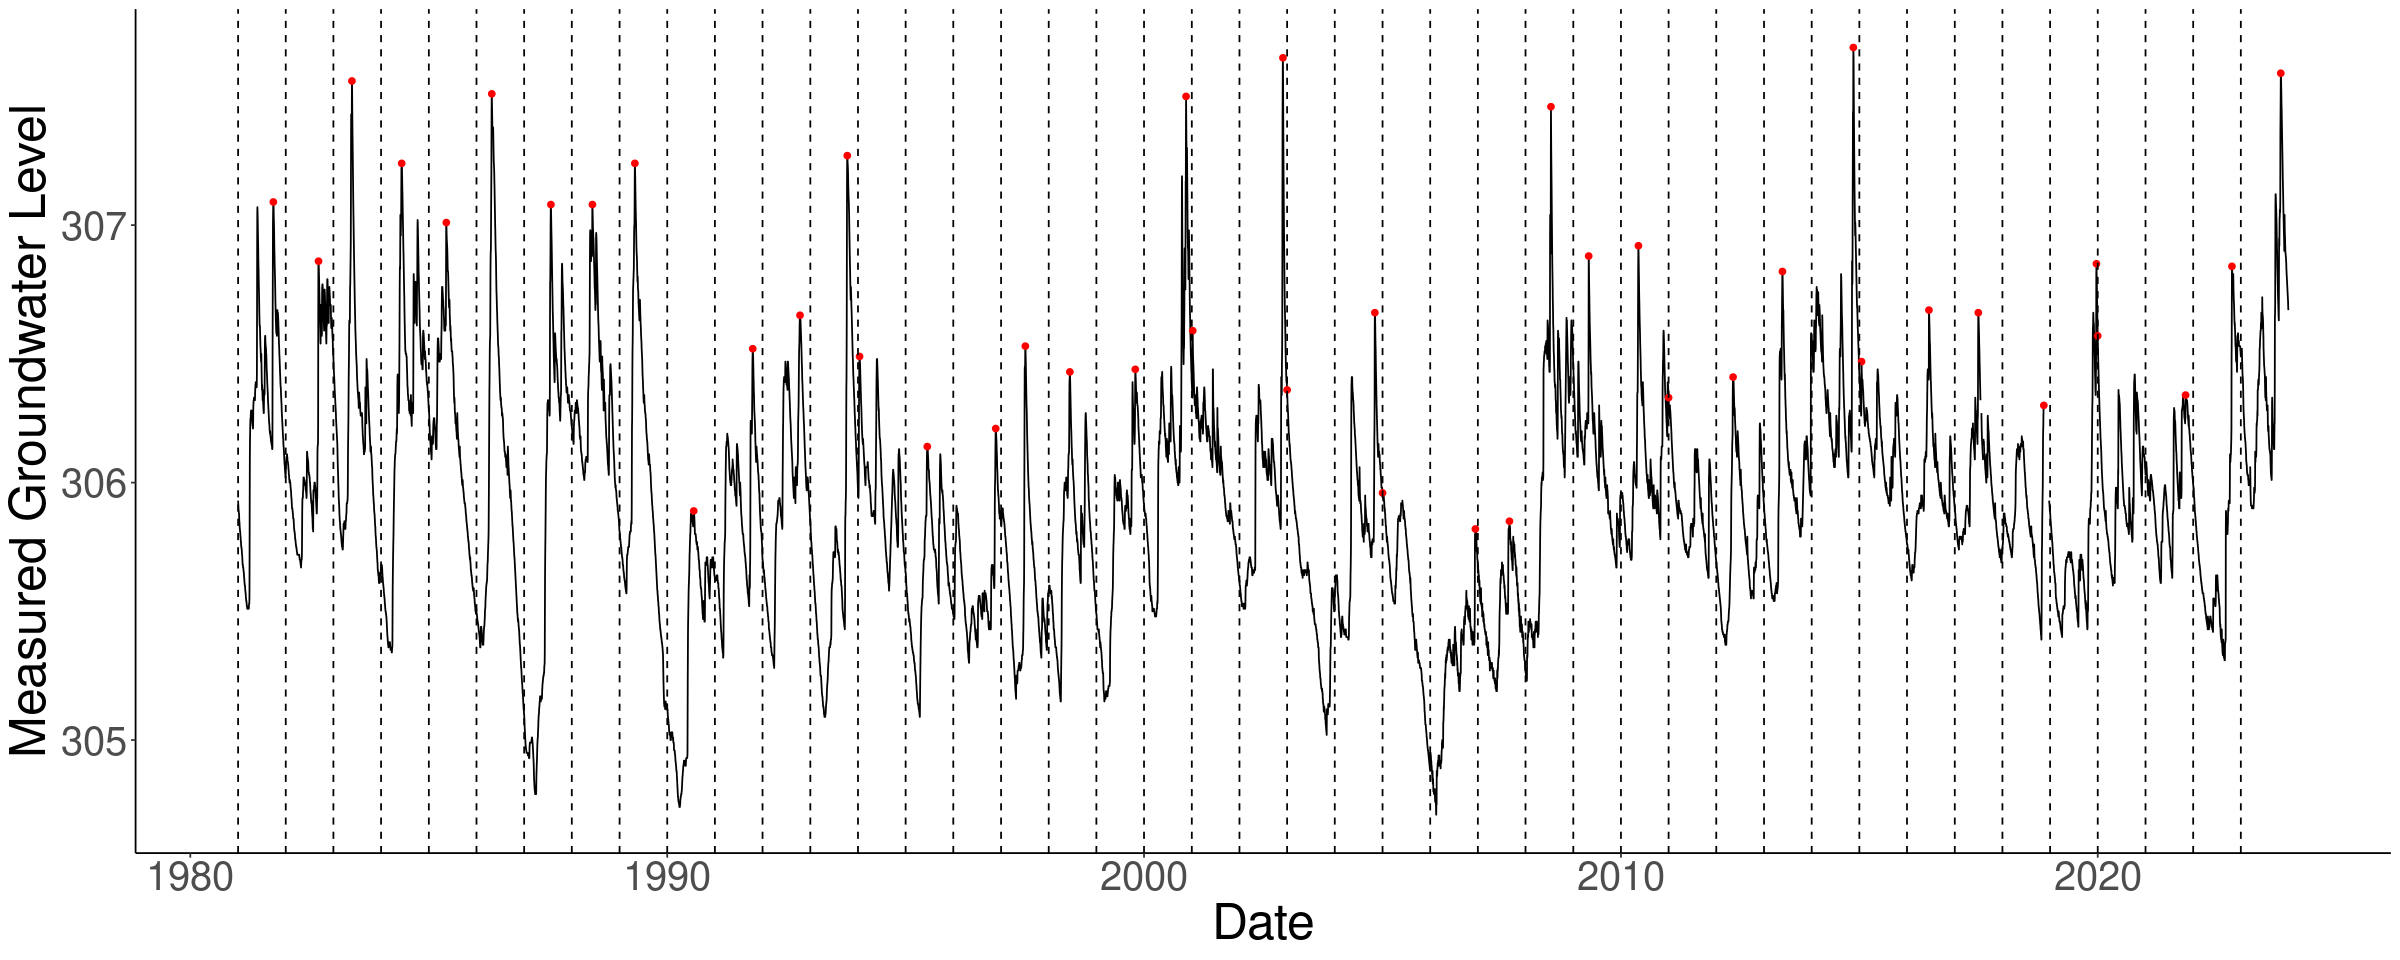

In [4]:
# Increase the plot size
options(repr.plot.width=20, repr.plot.height=8)

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))), linetype = "dashed") + #add vertical line for each year
    theme_classic() + #Change template
    theme(text = element_text(size = 30))+ #Increase police size
    xlab("Date") + # X axis name
    ylab("Measured Groundwater Level") #Y axis name

The above plots is extremely informative: we do not observe an obvious non-stationary trend in time. This observation was confirmed by estimating a trend thanks to the `mgcv` package which was found flat; see example 3 and 4 for implementation details of the trend estimation. The distribution of the maxima can thus reasonably be assumed "identically distributed". We will now check the second assumption, i.e., the independence of yearly maxima.

## Checking the independence of yearly maxima measurements

Independence of the yearly maxima will be checked thanks to an auto-correlation function: we compute the correlation between the maxima at year `y` and values at year `y + lag`. The empirical estimate of the function can be computed automatically using the function `acf`.

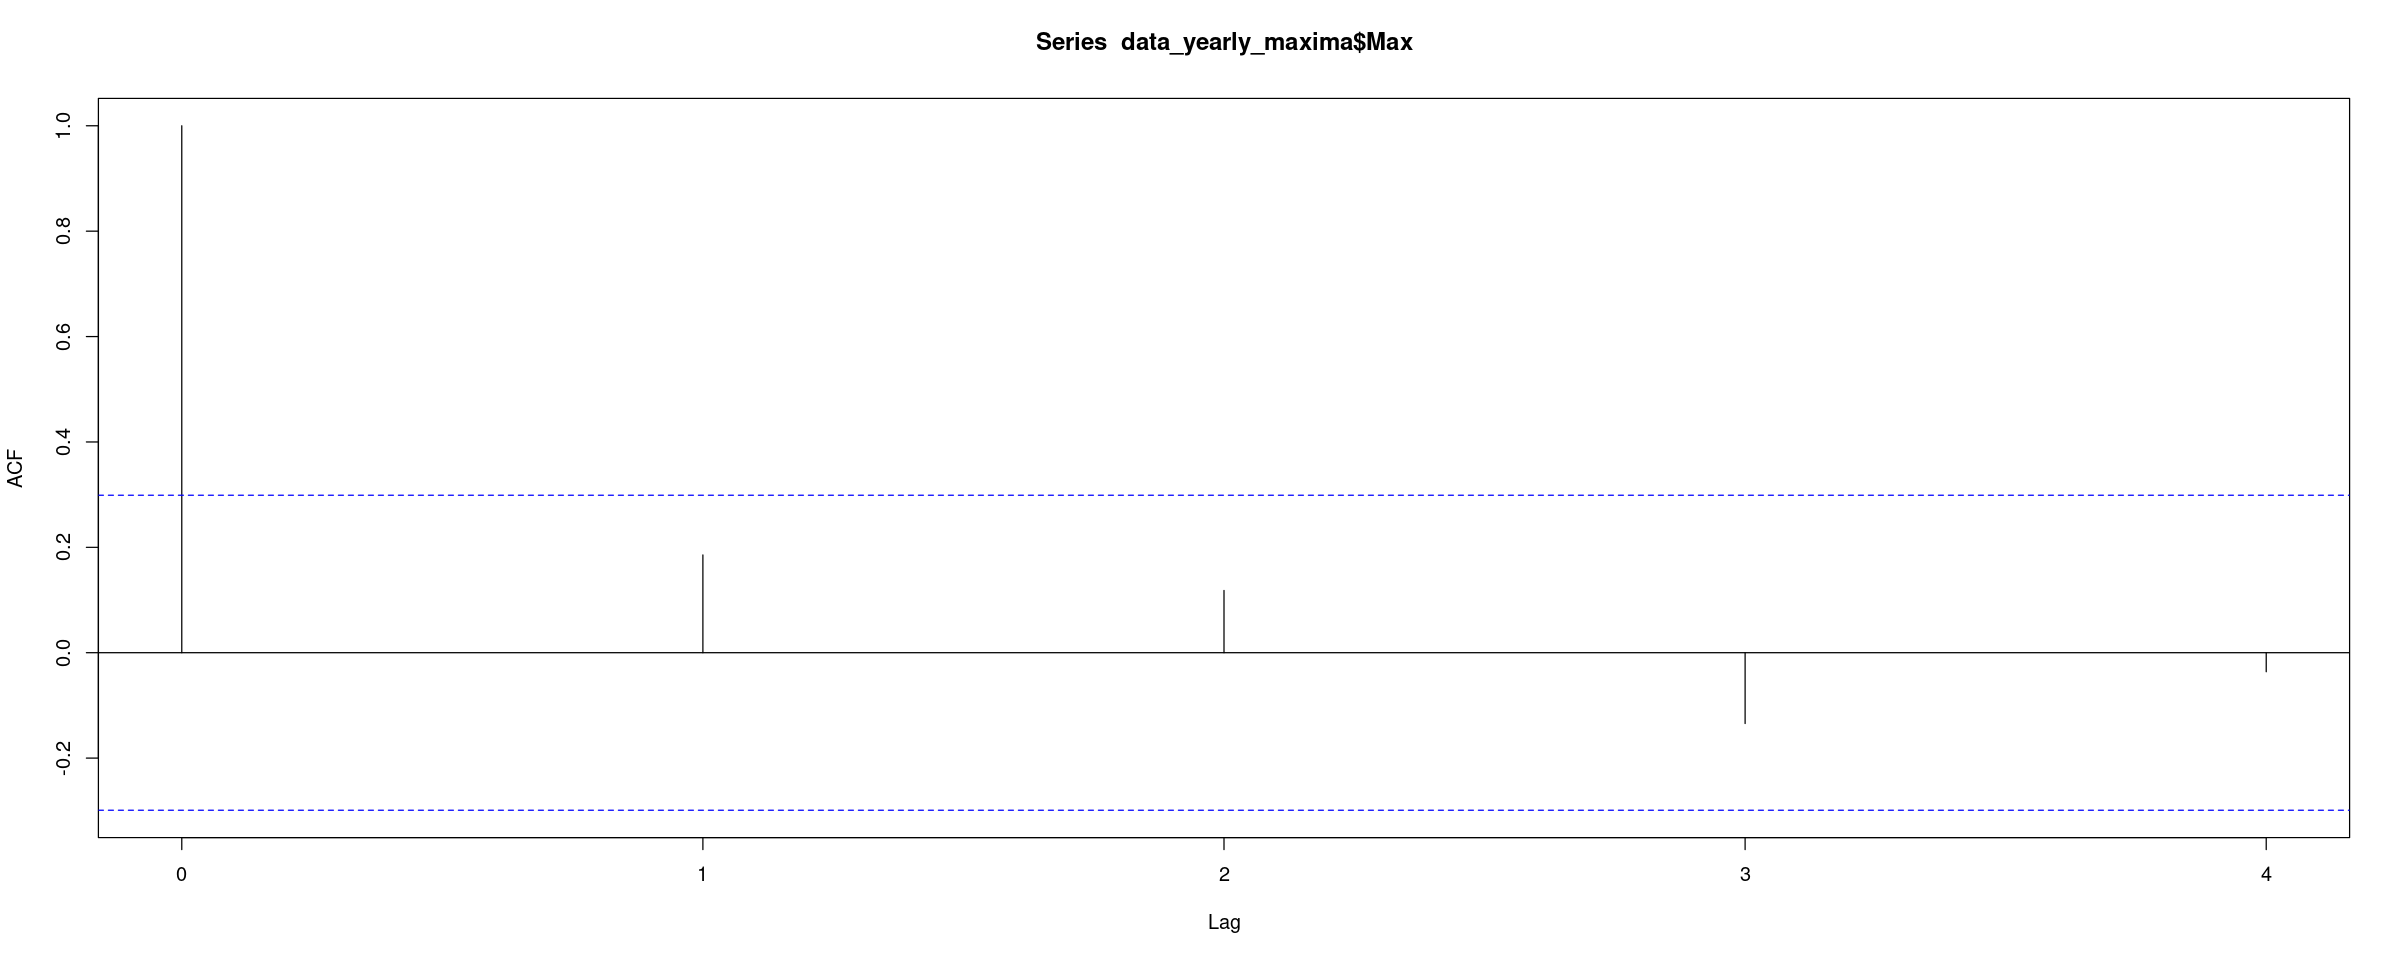

In [5]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima$Max, lag = 4, na.action = na.pass)

The function's value at lag `0` is equal to `1` and corresponds to the perfect match between a maxima and itself. At lags `lag > 1`, the correlation remains below the dashed blue line, meaning that there is no evidence in favour of a correlation greater than `0`: the assumption of independence between measurements is reasonable and we can now move to the next step, i.e., model estimation and selection.

Even though there is no evidence of dependence in average, we observe that, in some rare occasions, maxima occur during the same high groundwater peak indicating obvious evidence of dependence. We thus attempt to limit this phenomenon by using yearly blocks that starts at another date than January 1st.

In [6]:
#Define block starting date for the first year
starting_date <- ymd("1981-03-01")

# Compute number of days to shift date
number_of_days_since_start_of_year <- starting_date - min(data$Zeitstempel)

# Compute block index by shifted years
data$block_index <- year(data$Zeitstempel - number_of_days_since_start_of_year) - min(data$Jahre)

#Compute yearly maxima for shifted blocks
data_yearly_maxima_shifted <- data %>%
                        group_by(block_index) %>% # Groupe lines by year
                        summarize(Max = max(Wert, na.rm = TRUE),
                                  Date_maxima = Zeitstempel[which.max(Wert)]) # Compute yearly maxima and date of occurence

#Display first 6 rows of the dataframe
head(data_yearly_maxima_shifted) 

block_index,Max,Date_maxima
<dbl>,<dbl>,<date>
-1,305.93,1981-01-01
0,307.09,1981-09-28
1,306.86,1982-09-09
2,307.56,1983-05-23
3,307.24,1984-06-07
4,307.01,1985-05-15


We now plot the time series along with the maxima of shifted blocks.

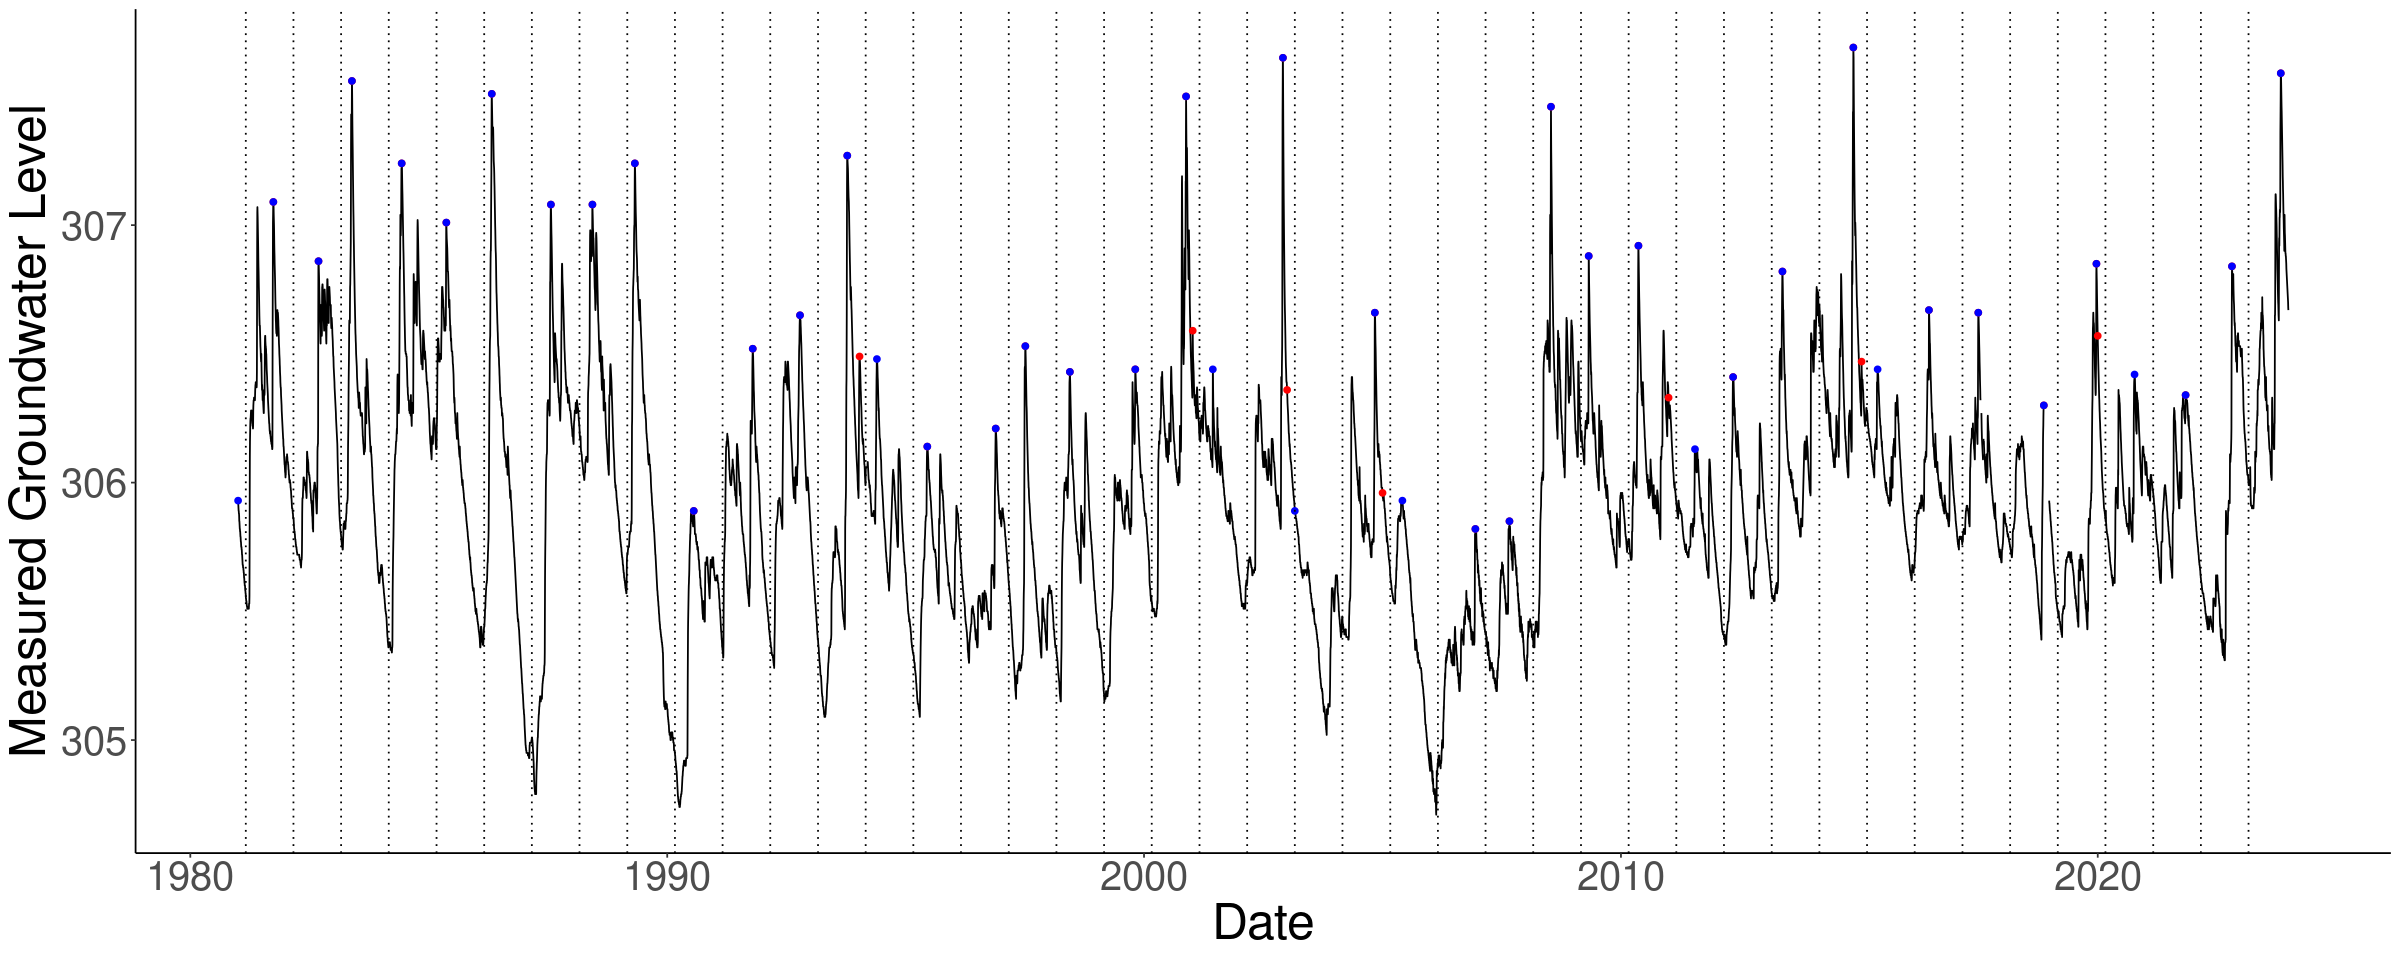

In [7]:
# Increase the plot size
options(repr.plot.width=20, repr.plot.height=8)

# Use the ggplot2 package to display the time series
ggplot(data) + #create plot object
    geom_line(data = data, aes(x = Zeitstempel, y = Wert)) + # add time series of measurements
    geom_point(data = data_yearly_maxima, aes(x = Date_maxima, y = Max), color = "red") + #add maxima as red points
    geom_point(data = data_yearly_maxima_shifted, aes(x = Date_maxima, y = Max), color = "blue") + #add maxima of shifted blocks as blue points
    geom_vline(xintercept = dmy(paste0("01-01-",seq(min(data$Jahre), max(data$Jahre), by = 1))) + number_of_days_since_start_of_year, linetype = "dotted") + #add vertical line for each shifted block
    theme_classic() + #Change template
    theme(text = element_text(size = 30))+ #Increase police size
    xlab("Date") + # X axis name
    ylab("Measured Groundwater Level") #Y axis name

We observe that the few events that shared the same high groundwater peak have now all been removed except one in 2003, however as the no high groundwater this year, there is no way to avoid such a situation. We could consider exclude data from 2003 for the analysis if there is a good hydrogeological justification. For now, we leave the observation as is. 

We can now check if the maxima of shifted blocks, similarly to the original calendar year blocks, displays evidences in favor of the existence of positive average dependence thanks to the `acf` function. 

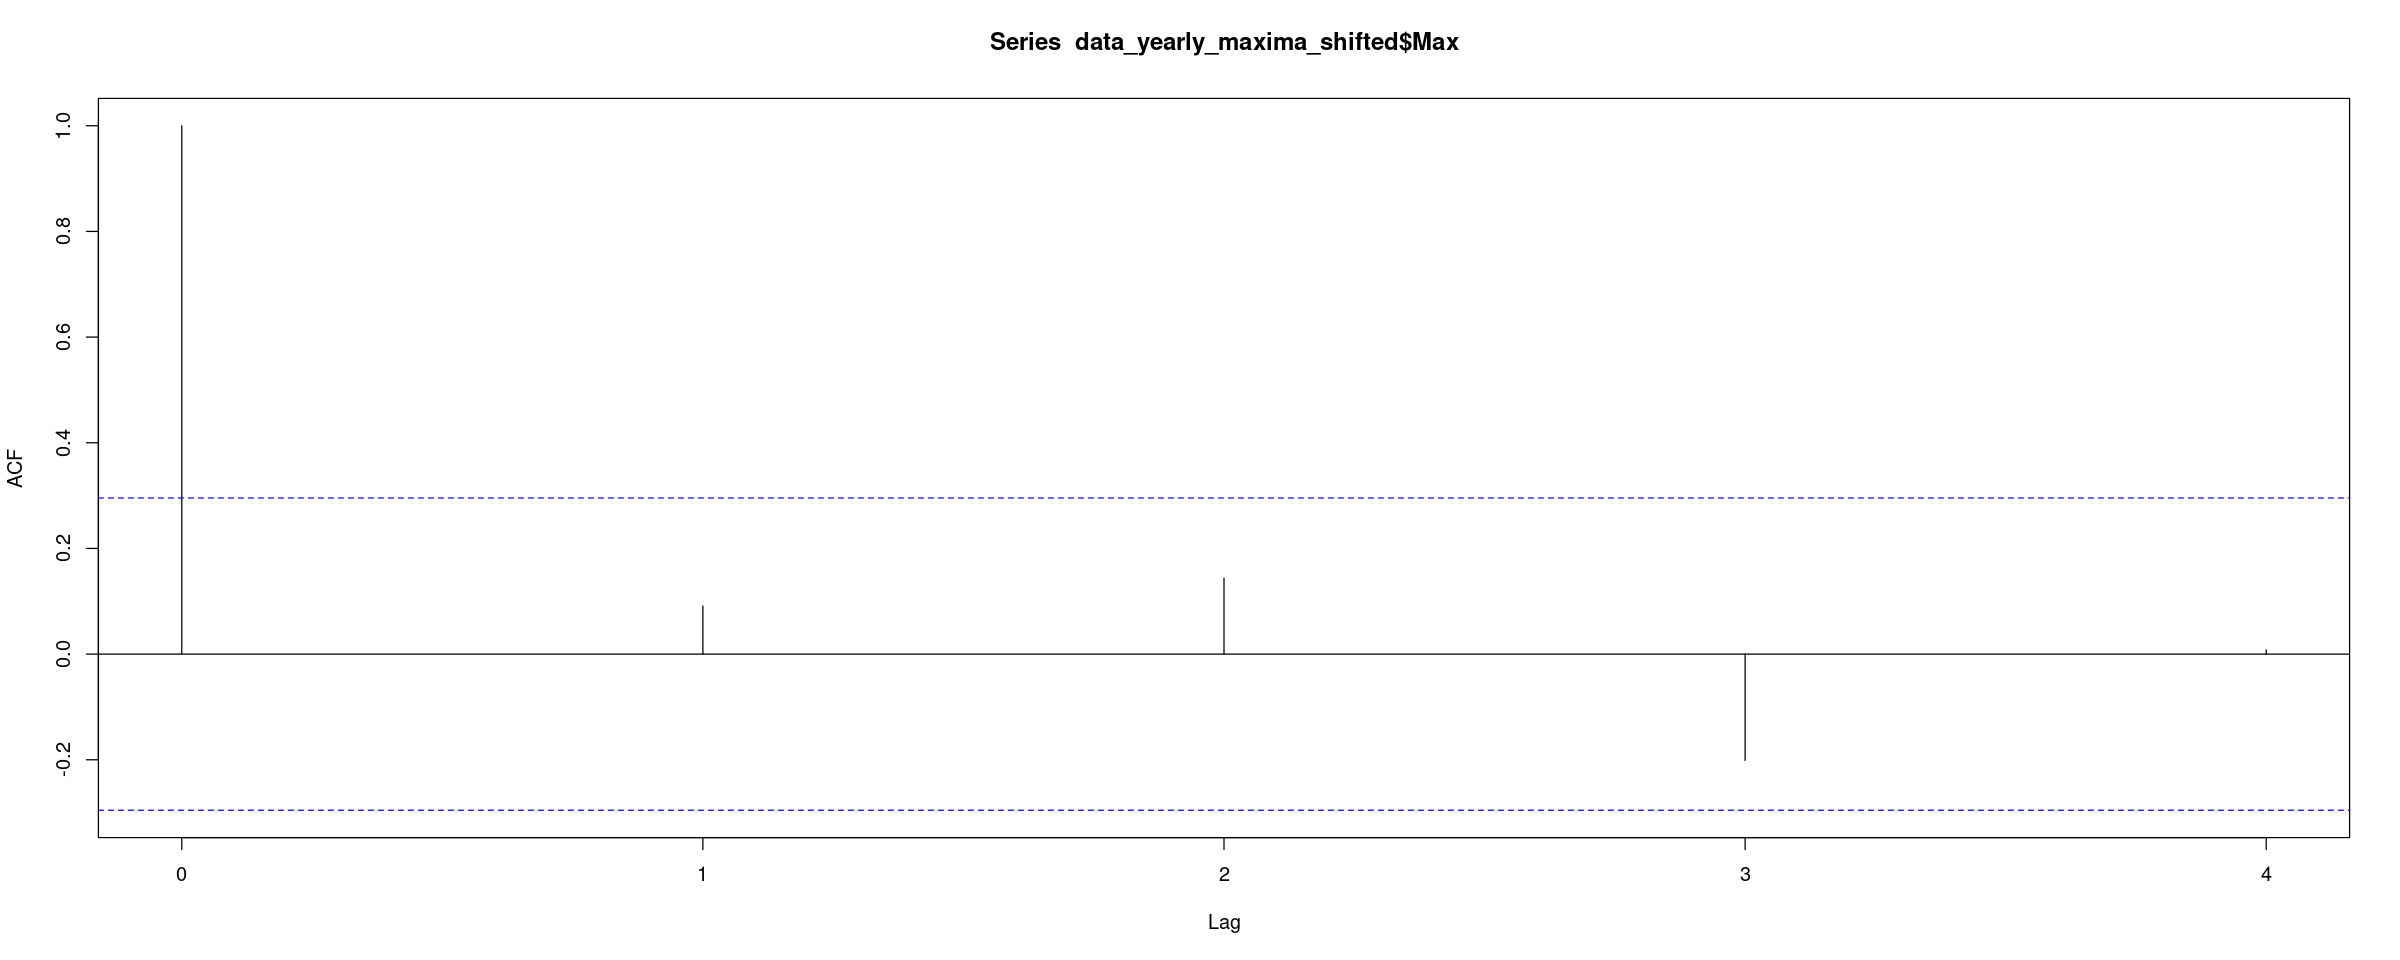

In [8]:
#Compute the auto-correlation between yearly maxima
acf(data_yearly_maxima_shifted$Max, lag = 4, na.action = na.pass)

Not surprinsingly, there is again no evidence against independence so we will continue the analysis using the maxima of shifted blocks.

For the very begininning of the time series, the first shifted block includes only 2 months of observations: for such a short period there is no reason to believe that the maxima has reasonably been observed so we leave out the first maxima for the rest of the analysis.

In [9]:
# Filter block maxima data to remove the maximum of the first shifted block
# corresponding to the first 2 months of measurements
data_yearly_maxima_shifted <- data_yearly_maxima_shifted %>% filter(block_index != -1)
head(data_yearly_maxima_shifted)

block_index,Max,Date_maxima
<dbl>,<dbl>,<date>
0,307.09,1981-09-28
1,306.86,1982-09-09
2,307.56,1983-05-23
3,307.24,1984-06-07
4,307.01,1985-05-15
5,307.51,1986-04-28


## Model estimation and selection

We estimate and select a parametric model for the block maxima observations. As we have less than `100` observations, we will prefer L-moment matching over maximum likelihood estimation as the former is known to provide more robust estimates for small sample sizes.

We consider three models:
* <ins> Generalized Extreme Value (GEV)</ins> : the model is theoretically motivated as it appears as the asymptotic distribution for the distribution of block maxima of increasing size. It is thus a natural candidate for observations representing the maxima over a block.
* <ins> Log-Pearson III</ins>: this model is extremely popular in hydrology. It is parametrized with the same number of parameters than the GEV, and is sometime found to be a better fit to the data. Its popularity makes it an important candidate.
* <ins> Weibull distribution</ins>: the Weibull model is a specific case of the GEV when the model admits an upper bound. We observe empirically that groundwater level usually falls into this category. Estimating directly a Weibull distribution instead of a GEV sometime can provide a better fit to the data when the added constraint that there is an upper bound to the data is realistic, see the guidelines' report for more details.

We thus use the `R` package `lmom` to estimate the parameters the three candidate models.

In [10]:
#Comput l-moments of the observations
lmom <- samlmu(data_yearly_maxima_shifted$Max)

#Estimate GEV parameters
gev <- pelgev(lmom)

#Estimate log-Pearsonn III parameters
pIII <- pelpe3(lmom)

# Compute Weibull parameters
wei <- pelwei(lmom)

print("GEV Parameters:")
gev
print("Weibull Parameters:")
wei
print("Log-Pearson III:")
pIII

[1] "GEV Parameters:"


xi       alpha           k 
306.5214786   0.5256799   0.2175785

[1] "Weibull Parameters:"


zeta       beta      delta 
305.303615   1.601021   2.838617

[1] "Log-Pearson III:"


mu       sigma       gamma 
306.7300000   0.5486593   0.2300001

We now have parameters estimates for all the three candidate models. We will select the best fitting one by computing their respective negative-log likelihood and choosing the one with the lowest value.

In [11]:
print("Neg-log likelihood:")
(paste0("GEV: ",-sum(log(evd::dgev(data_yearly_maxima_shifted$Max, loc = gev[1], scale = gev[2], shape = -gev[3])))))
(paste0("Weibull: ",-sum(log(dweibull(data_yearly_maxima_shifted$Max - wei[1],scale = wei[2], shape = wei[3])))))
(paste0("Pearson3: ",-sum(log(dgamma(abs(data_yearly_maxima_shifted$Max - (pIII[1] - 2 *  pIII[2] /  pIII[3])), shape = 4/(pIII[3])^2, scale =  pIII[2] * abs(pIII[3]) / 2)))))

[1] "Neg-log likelihood:"


[1] "GEV: 33.1537910495898"

[1] "Weibull: 32.8754112801561"

[1] "Pearson3: 33.4685894233425"

We observe that the model with minimal negative log-likelihood is the classical Weibull distribution. The GEV estimation correspond to a reverse Weibull distribution and the estimation method yields parameters values that are more likely than Pearson III but less likely than classical Weibull estimation.

We thus choose the classical Weibull model with direct parameters' estimates to compute the return level function of the yearly maxima.

## Return level function estimation

The selected parametric model can be translated into a return level function, i.e., the expected groundwater level yearly maxima expected to be observed in average every return period (in years).

We also quantify the uncertainty associated to the estimated model in order to check if the selected model is consistent with the observed data. To do so, we will use a parametric boostrap method, i.e., a form a Monte Carlo sampling, that allows to quantify the uncertainty of the estimated return levels.

In [12]:
#Importa all necessary functions
source("utils.r")

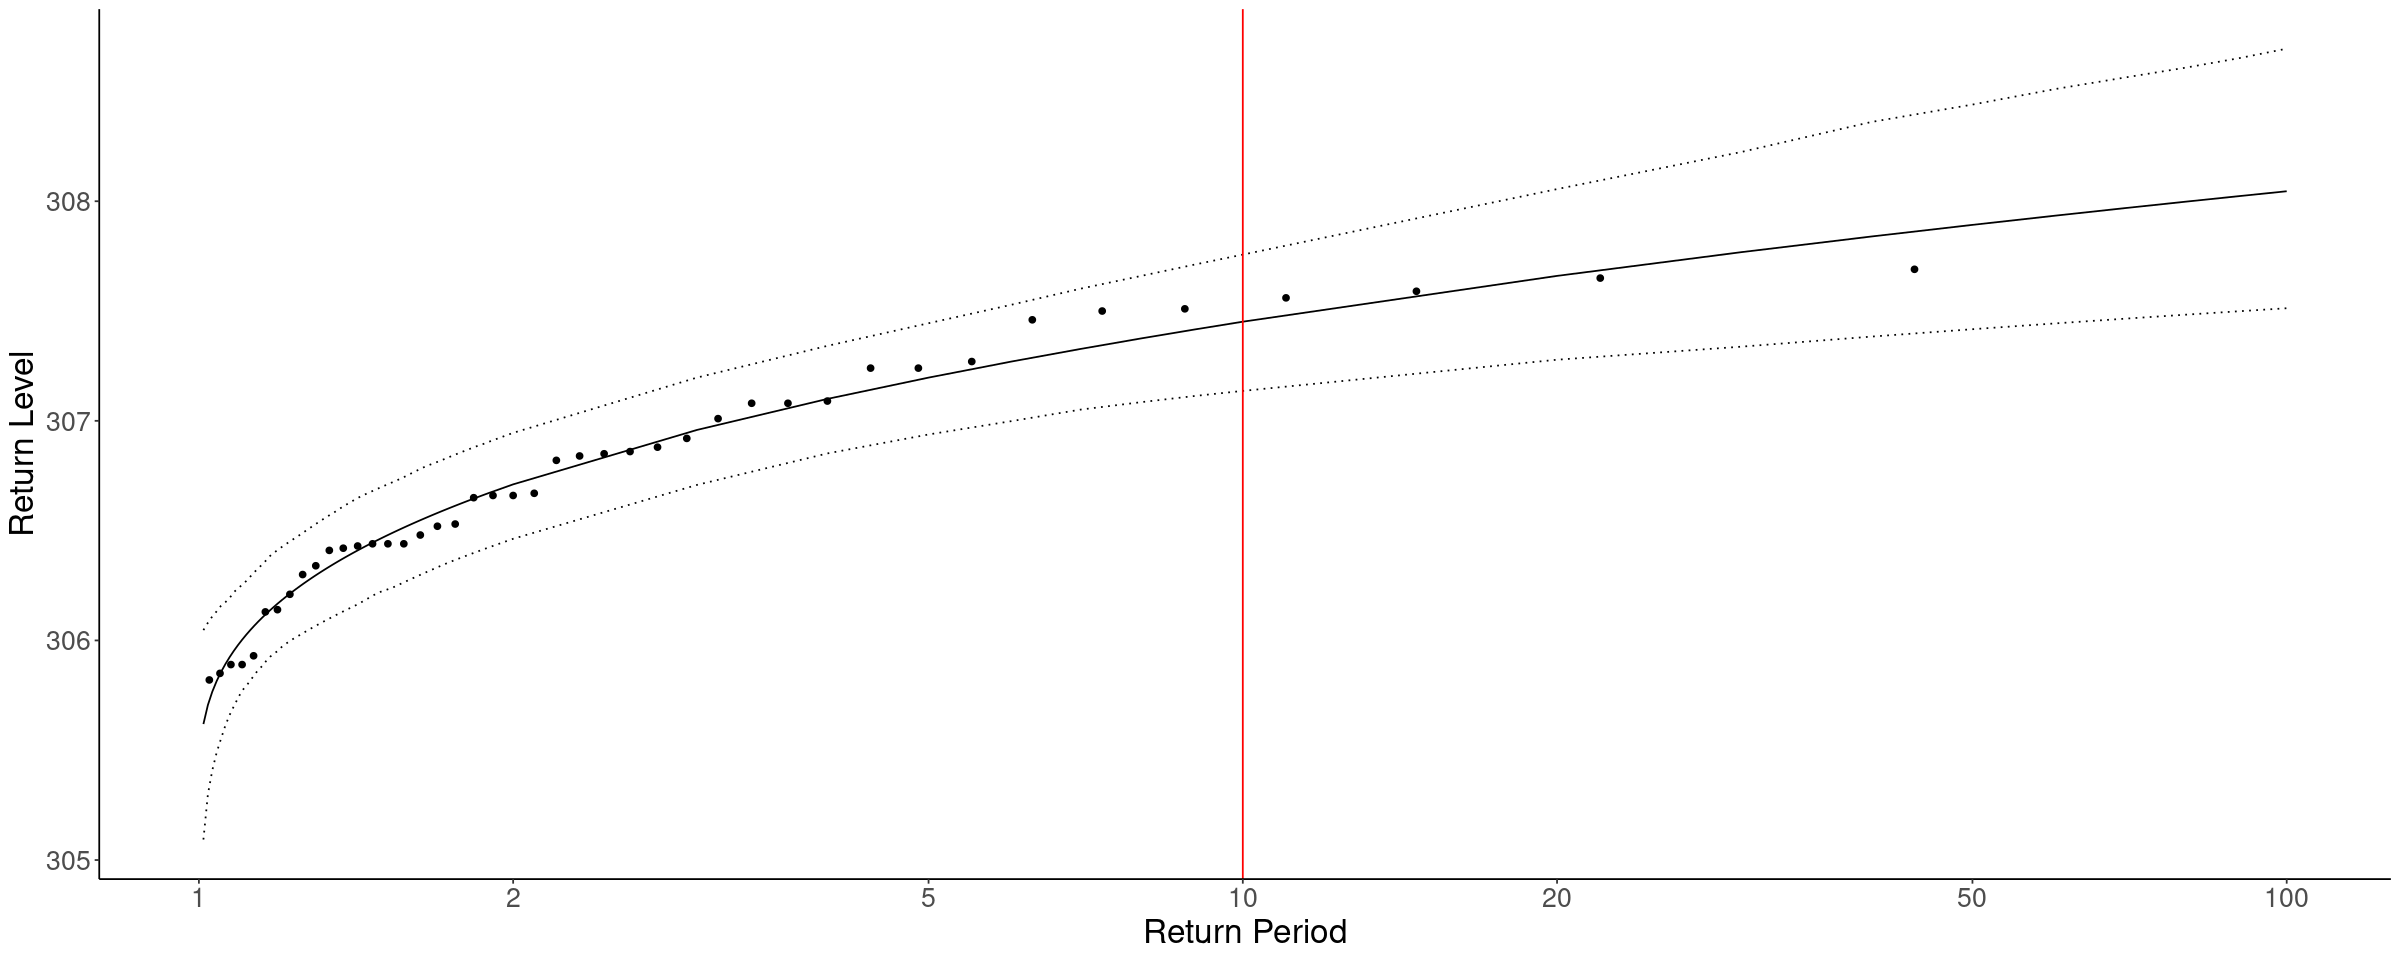

In [13]:
#Compute and plot the return level function and its associated uncertainty
display_return_level_function(data = data_yearly_maxima_shifted$Max,
                              parameters = wei)

We observe that all maxima lie inside the uncertainty bound, namely the 99% confidence interval represented by the dotted black lines: the estimated model is thus consistent with observations. The strenght of the parametric model described here is its capacity to extrapolate return level beyond the range of observed data. When using distributions covered by the GEV model such extrapolation is mathematically grounded in asymptotic theory.

We are now ready to compute the estimated return level for a given return period, in particular the 10 years return level that is particularly important for groundwater level regulation.

*<ins>Note on uncertainty quantification</ins>*: the confidence interval is obtained thanks to a bootstrap procedure. By nature, such technique for uncertainty quantification is random so the CI values might differ slightly from one execution to the other. Either rounding values to a sufficiently rough approximate, or increasing the bootstrap sample size `m` (at the cost of an increased computing time), would limit such variability to a low enough level. Note also that this procedure might not be fully robust for the Weibull model as for small sizes, samples might not be consistent with the existence of an upper bound yielding unconsistent bootstrap sample that needs to be rejected.

In [14]:
# Compute the desires return level and its uncertainty
return_levels <- compute_return_levels(return_period = c(5, 10, 20, 100), # Desired return period
                                      parameters = wei, # Parameters estimated from the selected model
                                      n_obs = length(data_yearly_maxima$Jahre), #Number of observations use for the estimation
                                      m = 1000 # Number of bootstrap samples for uncertainty quantification
                                     )
return_levels

Return_period,Lower_99_CI_bound,Return_level,Upper_99_CI_bound
<dbl>,<dbl>,<dbl>,<dbl>
5,306.9271,307.1969,307.4885
10,307.1008,307.4514,307.7702
20,307.2985,307.6601,308.0318
100,307.4796,308.0455,308.6191


We now have an estimate of the retrun level and its associated confidence interval that can be used as reference when designing civil engineering infrastructures compliant with the Swiss regulation.

## Fitting a GEV using Maximum Likelihood

The current example does not have more than 100 years of obserbations, so it is not recommended to use Maximum Likelihood Estimation over L-Moment matching. However, for illustration purposes, we provide a detailed implementation of how MLE can be implemented in `R`.

In [15]:
# Load the evd library
library(evd)

# Estimate GEV parameters using fgev function
gev_mle <- fgev(data_yearly_maxima_shifted$Max)

# Display parameters estimates
print("GEV Parameters:")
gev_mle$param

# Compute neg-log likelihood
print("Neg-log likelihood:")
(paste0("GEV: ",-sum(log(evd::dgev(data_yearly_maxima_shifted$Max, loc = gev_mle$param[1], scale = gev_mle$param[2], shape = gev_mle$param[3])))))

[1] "GEV Parameters:"


loc       scale       shape 
306.5495189   0.5208253  -0.3041438

[1] "Neg-log likelihood:"


[1] "GEV: 32.8771975483129"

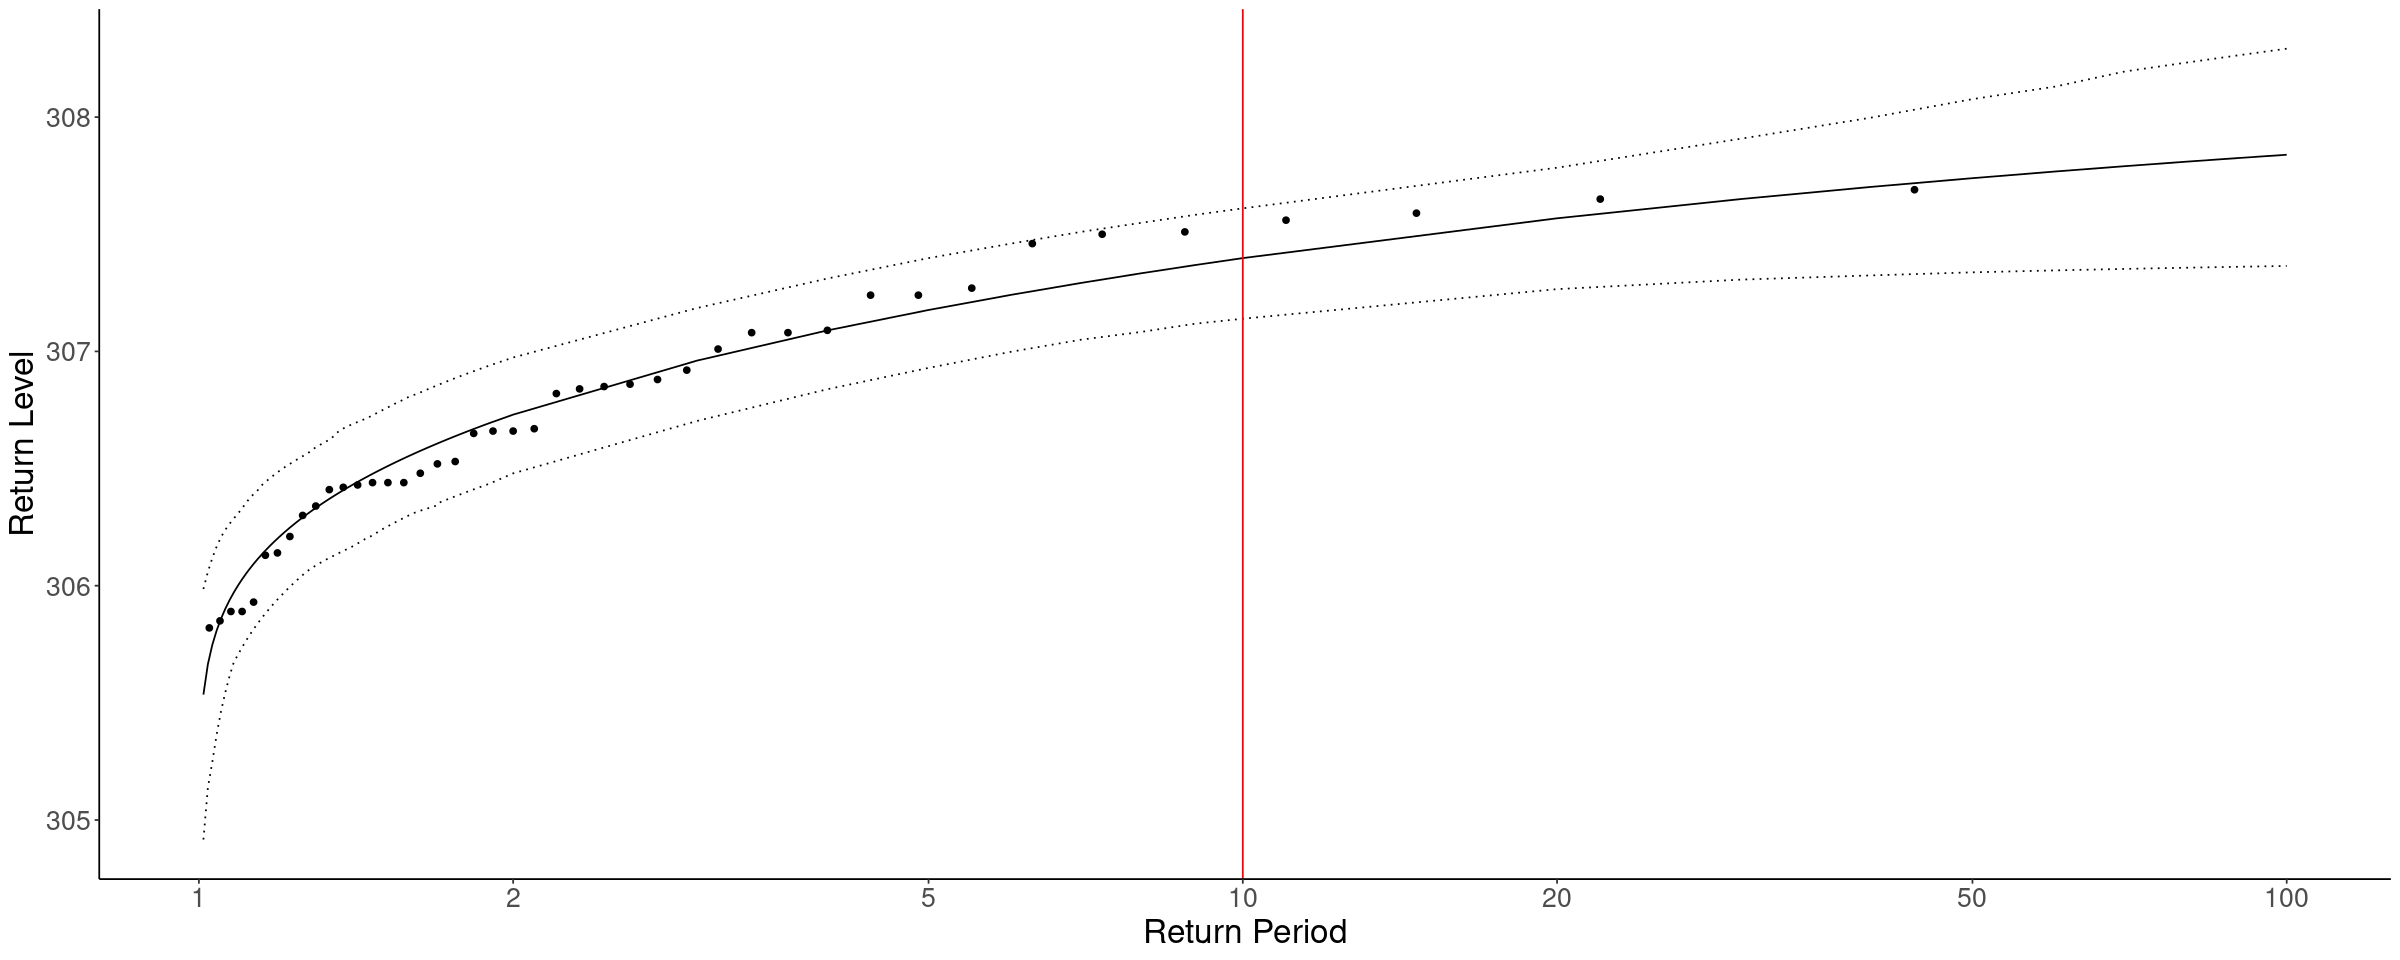

In [16]:
#Compute and plot the return level function and its associated uncertainty
display_return_level_function(data = data_yearly_maxima_shifted$Max,
                              parameters = gev_mle$param)

The estimated shape parameter being negative, thes estimated GEV model is upper bounded: compared the selected Weibull model, which does not admit an upper bound, the uncertainty for high return level is thus meant to be lower as it can be observed when comparing both plots. However, in this case, a few observation are located nearly outside the confidence interval which reveals the inadequacy of the GEV (revers Weibull) model over the classical Weibull.

In [17]:
return_levels <- compute_return_levels(return_period = c(5,10,20,100), # Desired return period
                                      parameters = gev_mle$param, # Parameters estimated from the selected model
                                      n_obs = length(data_yearly_maxima$Jahre), #Number of observations use for the estimation
                                      m = 1000 # Number of bootstrap samples for uncertainty quantification
                                     )
return_levels

Return_period,Lower_99_CI_bound,Return_level,Upper_99_CI_bound
<dbl>,<dbl>,<dbl>,<dbl>
5,306.9447,307.1768,307.4048
10,307.1066,307.3982,307.6123
20,307.2572,307.5681,307.7965
100,307.3284,307.8393,308.2406
